In [1]:
import torch
import gpytorch
from bilateral_kernel import BilateralKernel

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda-10.0'


In [2]:
kernel = BilateralKernel()

In [3]:
N_vals = torch.linspace(100, 10000000, 10).int().tolist()
D_vals = torch.linspace(1, 100, 10).int().tolist()

# Matmul

In [4]:
import timeit

N_vary = []
for N in N_vals:
    D = 1
    x = torch.randn(N, D)
    K = BilateralKernel()(x)
    v = torch.randn(N, 1)
    def matmul():
        return K @ v
    time = timeit.timeit(matmul , number=10)

    N_vary.append([N, D, time])

    del x
    del K
    del v
    del matmul

In [5]:
D_vary = []
for D in D_vals:
    N = 1000
    x = torch.randn(N, D)
    K = BilateralKernel()(x)
    v = torch.randn(N, 1)
    def matmul():
        return K @ v
    time = timeit.timeit(matmul , number=10)

    D_vary.append([N, D, time])

    del x
    del K
    del v
    del matmul

In [6]:
import pandas as pd
N_vary = pd.DataFrame(N_vary, columns=["N", "D", "Time"])
D_vary = pd.DataFrame(D_vary, columns=["N", "D", "Time"])

In [7]:
import seaborn as sns
ax = sns.lineplot(data=N_vary, x="N", y="Time")
ax.set(title="Matmul (D=1)")

[Text(0.5, 1.0, 'Matmul (D=1)')]

Coefficients: 
 [2.24871438]


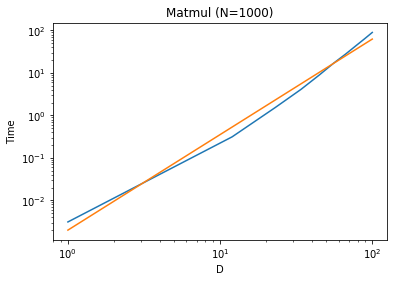

In [8]:
from sklearn.linear_model import LinearRegression
import numpy as np
regr = LinearRegression()
regr.fit(np.log(D_vary["D"].to_numpy()[:, None]), np.log(D_vary["Time"]))
print('Coefficients: \n', regr.coef_)
pred_time = regr.predict(np.log(D_vary["D"].to_numpy()[:, None]))

ax = sns.lineplot(data=D_vary, x="D", y="Time")
ax.set(title="Matmul (N=1000)", xscale="log", yscale="log")
ax.plot(D_vary["D"].to_numpy(), np.exp(pred_time))

# Gradient

In [36]:
import timeit

N_vary = []
for N in N_vals:
    D = 1
    x = torch.randn(N, D, requires_grad=True)
    K = BilateralKernel()(x)
    v = torch.randn(N, 1, requires_grad=True)
    sum = (K @ v).sum()
    def gradient():
        torch.autograd.grad(sum, [x, v], retain_graph=True)
        x.grad = None
        v.grad = None
        return
    time = timeit.timeit(gradient, number=10)

    N_vary.append([N, D, time])

    del x
    del K
    del v
    del gradient

In [37]:
import timeit

D_vary = []
for D in D_vals:
    N = 1000
    x = torch.randn(N, D, requires_grad=True)
    K = BilateralKernel()(x)
    v = torch.randn(N, 1, requires_grad=True)
    sum = (K @ v).sum()
    def gradient():
        torch.autograd.grad(sum, [x, v], retain_graph=True)
        x.grad = None
        v.grad = None
        return
    time = timeit.timeit(gradient, number=10)

    D_vary.append([N, D, time])

    del x
    del K
    del v
    del gradient

In [38]:
import pandas as pd
N_vary = pd.DataFrame(N_vary, columns=["N", "D", "Time"])
D_vary = pd.DataFrame(D_vary, columns=["N", "D", "Time"])

[Text(0.5, 1.0, 'Gradient computation of (K@v).sum() (D=1)')]

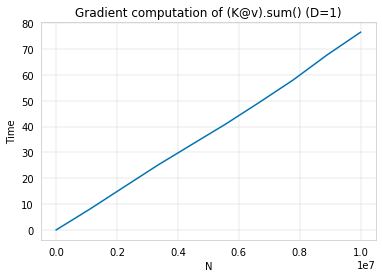

In [41]:
import seaborn as sns
ax = sns.lineplot(data=N_vary, x="N", y="Time")
ax.set(title="Gradient computation of (K@v).sum() (D=1)")

Coefficients: 
 [2.22456366]


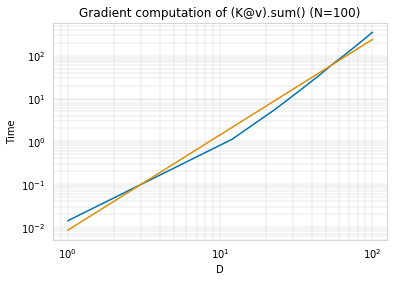

In [42]:
from sklearn.linear_model import LinearRegression
import numpy as np
regr = LinearRegression()
regr.fit(np.log(D_vary["D"].to_numpy()[:, None]), np.log(D_vary["Time"]))
print('Coefficients: \n', regr.coef_)
pred_time = regr.predict(np.log(D_vary["D"].to_numpy()[:, None]))

ax = sns.lineplot(data=D_vary, x="D", y="Time")
ax.set(title="Gradient computation of (K@v).sum() (N=100)", xscale="log", yscale="log")
ax.plot(D_vary["D"].to_numpy(), np.exp(pred_time))